# Objective
The goal for the model is to distinguish tweets about climate change into one of the three labels:
* 2: news - factual news about the climate change
* 1: pro - support the belief that climate change is caused by the man-kinds.
* 0: neutral
* -1: anti - refuse the belief that climate change is caused by the man-kinds

# EDA


## Load Packages and Data
Before analyzing data, we need to import required packages and the dataset.

In [69]:
pip install pydataset

Note: you may need to restart the kernel to use updated packages.


In [91]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

In [92]:
df = pd.read_csv('train.csv')
df.head(10)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming an...,625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t....,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is ...",466954
5,1,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun...,425577
6,1,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lun...,294933
7,1,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or ho...",992717
8,1,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but ...",664510
9,1,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,260471


In [93]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"])

## Data Dictionary

In [94]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming an...,625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t....,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is ...",466954


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


There are total of 43949 entries with no null counts.

## Distribution of Sentiments

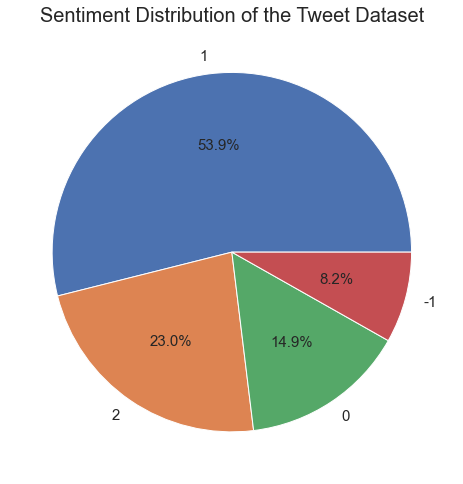

In [96]:
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

The pie chart shows the distribution of the data. Majority of tweets are labelled as "1" meaning the positive attitude toward the belief that the climate change is caused by the man-kinds, followed by "2"(news), "0"(neutral), and "-1"(anti).

In [97]:
df.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

These are the exact numbers of each sentiment label.

# Data Preparation for Sentiment Analysis
Tweet texts will be transformed and vectorized to be fed into models.

In [98]:
# separate the messages column for transformation.
dfTweets = df["message"]

## Tokenization
All the tweets are first split into arrays of words.

In [99]:
def createTokenizedArray(sentences):
    '''
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    '''
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [100]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [polyscimajor, epa, chief, doesn, t, think, carbon, dioxide, is, main, cause, of, glob...
1                   [it, s, not, like, we, lack, evidence, of, anthropogenic, global, warming]
2    [rt, rawstory, researchers, say, we, have, three, years, to, act, on, climate, change,...
3    [todayinmaker, wired, 2016, was, a, pivotal, year, in, the, war, on, climate, change, ...
4    [rt, soynoviodetodas, it, s, 2016, and, a, racist, sexist, climate, change, denying, b...
dtype: object

Each array contains words of individual tweet.

## Stop Word Removal
Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.

In [101]:
# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
    '''
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    '''
    stopWords = set(stopwords.words('english'))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\X475905\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['polyscimajor', 'epa', 'chief', 'doesn', 't', 'think', 'carbon', 'dioxide', 'is', 'main', 'cause', 'of', 'global', 'warming', 'and', 'wait', 'what', 'https', 't', 'co', 'yelvcefxkc', 'via', 'mashable']


Sample sentence AFTER removing stop words:
['polyscimajor', 'epa', 'chief', 'think', 'carbon', 'dioxide', 'main', 'cause', 'global', 'warming', 'wait', 'https', 'co', 'yelvcefxkc', 'via', 'mashable']


You can see the second set of the array now no longer contains some insignificant words such as "is", "an", "as" and "it".

## Stemming
English words are often time variations of a root word. Stemming rebuilds sentences by removing suffixes from words. It potentially improves the sentiment algorithm by accepting different words as one word as long as they were originated from the same stem.

In [103]:
def stemWords(sentenceArrays):
    '''
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    '''
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = ' '
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [104]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['polyscimajor', 'epa', 'chief', 'think', 'carbon', 'dioxide', 'main', 'cause', 'global', 'warming', 'wait', 'https', 'co', 'yelvcefxkc', 'via', 'mashable']

Sample sentence AFTER stemming:
polyscimajor epa chief think carbon dioxid main caus global warm wait http co yelvcefxkc via mashabl


## Vectorization
Now the stemmed sentences will be vectorized. It essentially transforms all the existing words into numbers so they can be fed to various big data algorithms.

In [105]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [106]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

Let's look into 2 different sample sentences to understand better what vectorization does

In [107]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
polyscimajor epa chief think carbon dioxid main caus global warm wait http co yelvcefxkc via mashabl
Sample sentence #2:
like lack evid anthropogen global warm


Notice these 2 sentences have a couple of words in common - "climat", "chang"

In [108]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
  (0, 4730)	1
  (0, 4855)	1
  (0, 5189)	1
  (0, 5632)	1
  (0, 7051)	1
  (0, 8239)	1
  (0, 10066)	1
  (0, 11370)	1
  (0, 15005)	1
  (0, 15240)	1
  (0, 18740)	1
  (0, 23584)	1
  (0, 25167)	1
  (0, 25544)	1
  (0, 25590)	1
  (0, 26749)	1
#2 after vectorization:
  (0, 2669)	1
  (0, 8462)	1
  (0, 10066)	1
  (0, 14016)	1
  (0, 14445)	1
  (0, 25590)	1


The prints above show the results of 2 sample sentences after being ve. Each vector signifies a unique word in all tweets. For example, we already know they have 2 words in common; therefore, we can see 2 sets of vectors appearing in both sentences - **(0, 12943)** and **(0, 13774)** - which are representations of "climat" and "chang" respectively.

In [109]:
vectorizedTweets.shape

(15819, 27472)

Based on the column size of our vectorized data, we can see there were 67195 unique words (no stop words, stemmed) in 43943 tweets in the dataset.

## Bi-Grams
Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.

In [110]:
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [111]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]

Overall, it seems like tri-grams grab more accurate actions or emotions associated with climate change or global warming.

# Model Development
Various models will be built to predict the sentiment of tweets pertaining to climate change.

In [112]:
def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [113]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [114]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    '''
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    '''
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = ['Actual -1', 'Actual 0', 'Actual 1', 'Actual 2', ]
    Cols = ['Pred -1', 'Pred 0', 'Pred 1', 'Pred 2']
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))

    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title="Movie Review Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       horizontalalignment='right')

In [115]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [116]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [117]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

## 1. Logistic Regression

In [118]:
model = LogisticRegression()

C:\Users\X475905\OneDrive - Old Mutual\Documents\empty\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.7372945638432364
Precision: 0.7305084567104512
Recall:    0.7372945638432364
F1:        0.7286740230860643



[[ 146   55  127    9]
 [  25  251  234   41]
 [  31  111 1792  162]
 [   5   26  213  727]]


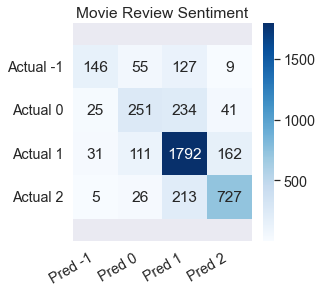

In [119]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram Logistic Regression

C:\Users\X475905\OneDrive - Old Mutual\Documents\empty\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.7044247787610619
Precision: 0.7025310123536809
Recall:    0.7044247787610619
F1:        0.684331210157729



[[ 105   45  152   13]
 [   9  192  353   41]
 [  11   95 1872  143]
 [   3   12  292  617]]


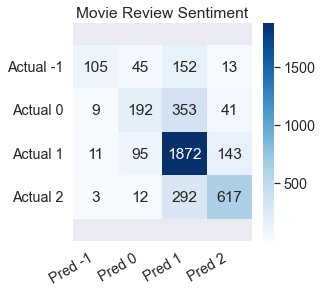

In [120]:
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(vectorizedTweets2, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### Tri-gram Logistic Regression

C:\Users\X475905\OneDrive - Old Mutual\Documents\empty\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.6758533501896333
Precision: 0.6928624473781803
Recall:    0.6758533501896333
F1:        0.629966653105123



[[  63   11  235   17]
 [   1   91  456   31]
 [  10   33 1996  102]
 [   2    8  376  523]]


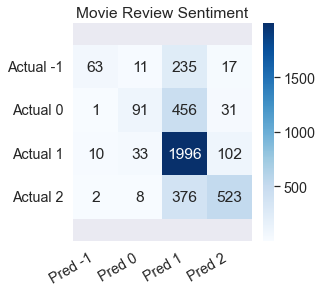

In [121]:
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(vectorizedTweets3, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### Bi-Gram & Tri-Gram Logistic Regression
Note that I was not able to vectorize data ranging from 1 to 3-gram due to memory issue on my device.

C:\Users\X475905\OneDrive - Old Mutual\Documents\empty\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



*** LogisticRegression ***
Accuracy:  0.7150442477876107
Precision: 0.7155067097017465
Recall:    0.7150442477876107
F1:        0.6943127383682262



[[  96   56  179   18]
 [   5  212  309   42]
 [   7   84 1920  157]
 [   6    8  256  600]]


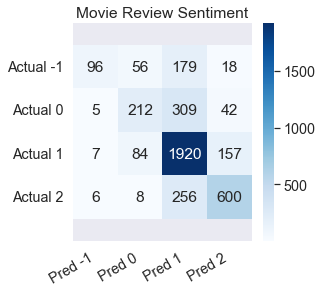

In [122]:
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(vectorizedTweets23, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

### N-gram Comparisons
We have built different vectorized sentences using different ranges of N-grams (1, 2, 3, and 2 to 3). Each of them was fed to a logistic regression model and evaluated based on classification scores such as accuracy, precision, recall and F1. In this section, we will compare all the scores and see what N-gram has worked the best.

In [123]:
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
-,0.737295,0.737295,0.730508,0.728674
Bi-gram,0.704425,0.704425,0.702531,0.684331
Tri-gram,0.675853,0.675853,0.692862,0.629967
Bi-gram and Tri-gram,0.715044,0.715044,0.715507,0.694313


Logistic regression has worked the best when no N-gram was used to vectorize the sentences. Let's see if we can improve the model even further using different classification models.

## 2. Decision Tree

In [124]:
model = DecisionTreeClassifier(max_depth=20)


*** DecisionTreeClassifier ***
Accuracy:  0.6323640960809103
Precision: 0.64340965252337
Recall:    0.6323640960809103
F1:        0.5931058357373048



[[  65   33  200   10]
 [   9  153  447   21]
 [  29   54 1893  115]
 [   8    1  527  390]]


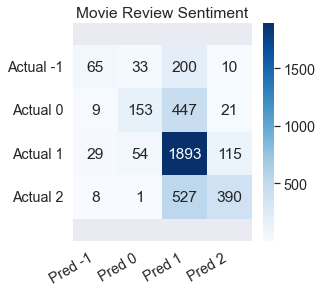

In [125]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 3. Random Forest Classifier

In [126]:
model = RandomForestClassifier()


*** RandomForestClassifier ***
Accuracy:  0.7082174462705436
Precision: 0.7147365503891425
Recall:    0.7082174462705436
F1:        0.6845267046752246



[[  81   34  195   12]
 [   2  196  343   32]
 [   8   89 1942  125]
 [   2   10  302  582]]


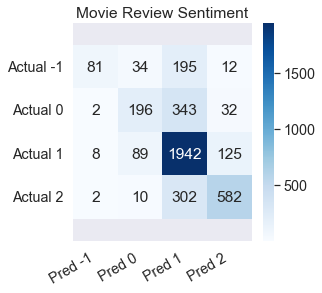

In [127]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 4. Extra Trees Classifier

In [128]:
model = ExtraTreesClassifier()


*** ExtraTreesClassifier ***
Accuracy:  0.7145385587863464
Precision: 0.7207210065311231
Recall:    0.7145385587863464
F1:        0.6938525784718416



[[  71   50  168   11]
 [   4  225  328   35]
 [   4  107 1882  124]
 [   1   10  287  648]]


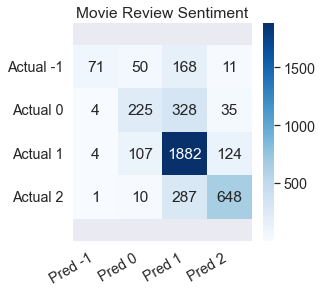

In [129]:
X_test, y_test, y_predicted, xtreeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 5. K Neighbors Classifier

In [130]:
model = KNeighborsClassifier()


*** KNeighborsClassifier ***
Accuracy:  0.4606826801517067
Precision: 0.6004066590798711
Recall:    0.4606826801517067
F1:        0.4752437172789678



[[  46  205   59    3]
 [  23  425  141    6]
 [  30 1001 1050   38]
 [  10  153  464  301]]


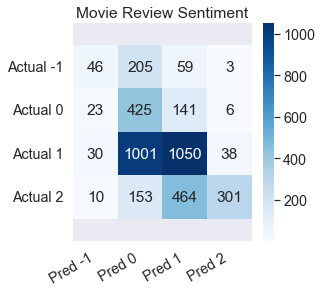

In [131]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

## 6. Linear Support Vector Classifier (SVC)

In [132]:
model = SVC()


*** SVC ***
Accuracy:  0.7261694058154236
Precision: 0.7333792787842899
Recall:    0.7261694058154236
F1:        0.6993959889388052



[[  86   33  196   10]
 [   4  176  362   38]
 [   7   50 1955  137]
 [   1    5  240  655]]


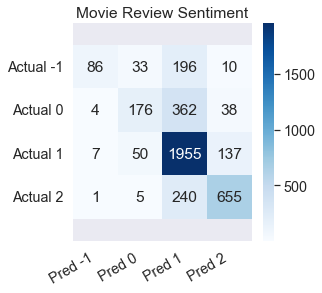

In [133]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

# Model Comparisons

In [136]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
xtreeScoreDf = pd.DataFrame(xtreeScoreDict, index=["Extra Trees Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(svcScoreDict, index=["Linear Support Vector Classifier Classification"])
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat([lrScoreDf, treeScoreDf, rfScoreDf, xtreeScoreDf, knnScoreDf, svcScoreDf, ridgeScoreDf])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending = False)

,accuracy,recall,precision,f1
Logistic Regression,0.737295,0.737295,0.730508,0.728674
Linear Support Vector Classifier Classification,0.726169,0.726169,0.733379,0.699396
Ridge Classification,0.722630,0.722630,0.714945,0.714660
Extra Trees Classification,0.714539,0.714539,0.720721,0.693853
Random Forest Classification,0.708217,0.708217,0.714737,0.684527
Decision Tree,0.632364,0.632364,0.643410,0.593106
K Neighbors Classification,0.460683,0.460683,0.600407,0.475244


**Logistic Regression** seems to be performing the best because it has the highest accuracy, recall, precision and f1 among all models. **SVC** and **Ridge Classification** are also good runner-ups.